In [15]:
import json
from tqdm import tqdm
import gensim
import spacy
import pandas as pd

In [2]:
with open('../data/processed/entities.json', 'r', encoding='utf8') as f:
    ents = json.load(f)

In [24]:
### get all the LOC entities detected by NER

def get_all_locs(ents):
    
    locs = {}
    
    for entry in tqdm(ents):
        if len(entry['ents']['LOC']) > 0:
            for loc in entry['ents']['LOC']:
                if loc[0] in locs.keys():
                    locs[loc[0]] += 1
                else:
                    locs[loc[0]] = 1
                    
    locs = pd.DataFrame(sorted(locs.items(), key=lambda x:x[1], reverse=True),
                        columns=['loc', 'count']).set_index('loc')
    
    return locs
               

In [27]:
locs = get_all_locs(ents)

100%|██████████████████████████████████████████████████████████████████████| 256996/256996 [00:01<00:00, 130603.57it/s]


In [81]:
toplocs = locs[locs['count'] > 300]
#toplocs[-50:]

<AxesSubplot:xlabel='loc'>

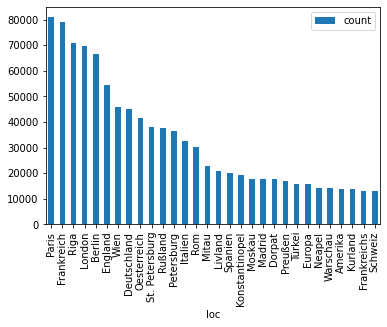

In [83]:
toplocs.iloc[:30].plot.bar()

In [64]:
model = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format('../data/models/word2vec_251021/w2v_model.txt')

In [109]:
def extend_locs(locs):
    
    all_locs = []
    
    for loc in tqdm(locs):
        if model.has_index_for(loc):
            sims = [sim[0] for sim in model.most_similar(loc, topn=20)]
            for sim in sims:
                if sim not in all_locs:
                    all_locs.append(sim)
                
    locs = list(locs) + all_locs
                
    return locs

In [110]:
extended_locs = extend_locs(toplocs.index)

100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:11<00:00, 54.47it/s]


In [118]:
testlist = ['Oesel', 'Narowa', 'Lille', 'Helsingfors', 'Worms', 'Fellin', 'Dago', 'Embach', 'Dwina', 'Aa', 'Wolmar']

for name in testlist:
    if name not in extended_locs:
        print(f'{name} not present!')

In [113]:
len(extended_locs)

6826

In [115]:
for name in testlist:
    print(model.most_similar(name, topn=5))

[('Oese', 0.8638697266578674), ('Oefel', 0.8015015721321106), ('Estland', 0.7755948305130005), ('Oescl', 0.7752076983451843), ('Moon', 0.7706601023674011)]
[('Ausflusse', 0.8379161953926086), ('Ladogasee', 0.822123110294342), ('Dwina', 0.8168364763259888), ('Welikaja', 0.8122370839118958), ('Angara', 0.8083022832870483)]
[('Grenoble', 0.8935690522193909), ('Lyon', 0.8872221112251282), ('Rouen', 0.8582719564437866), ('Toulouse', 0.8496144413948059), ('Rheims', 0.8327028155326843)]
[('Helsingsors', 0.8049711585044861), ('Helfingfors', 0.7843016386032104), ('Abo', 0.7752082347869873), ('HelsingforS', 0.7710840106010437), ('Kronstadt', 0.7681182026863098)]
[('Worm', 0.7097435593605042), ('WormS', 0.6975668668746948), ('Cleve', 0.6948642134666443), ('Hildesheim', 0.6874452233314514), ('Probstei', 0.6868461966514587)]
[('Wolmar', 0.8810287714004517), ('Werro', 0.8802183866500854), ('Pernau', 0.8778137564659119), ('Walk', 0.8705138564109802), ('Goldingen', 0.853241503238678)]
[('Dagoe', 0.868

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [122]:
list(model.get_vector(extended_locs[100]))

[1.5433208,
 1.0585272,
 -3.090225,
 0.21848029,
 -0.97422534,
 2.0327897,
 2.4291892,
 1.1988887,
 0.37492794,
 -0.3392877,
 1.4483565,
 -1.7513517,
 1.3962566,
 1.4541285,
 1.640056,
 -0.997179,
 -1.122343,
 -0.025651593,
 -2.3619757,
 0.15137447,
 -2.9399953,
 -2.9978497,
 3.5843813,
 -1.4673866,
 -0.4667782,
 -2.025675,
 -0.60258085,
 -1.0477096,
 -0.7873959,
 2.4707584,
 -0.03203789,
 0.6120957,
 0.9903852,
 0.45851484,
 0.57499266,
 0.86831677,
 1.6882758,
 -0.79834783,
 1.1535083,
 -1.0874205,
 -2.4567776,
 -0.34844387,
 -1.6779487,
 1.5070167,
 0.20446515,
 -1.6416638,
 0.28758982,
 0.91210157,
 -0.542621,
 0.286831,
 -0.6071744,
 -0.56816983,
 -0.37916476,
 -0.21069203,
 1.596786,
 -0.26234275,
 0.21588625,
 -0.1426483,
 -2.2261782,
 1.0580736,
 2.8349743,
 -0.72796196,
 -2.8188016,
 -2.7229397,
 1.1758231,
 -3.2602057,
 -0.53445804,
 0.0780662,
 -1.5536047,
 1.7847382,
 -2.3149474,
 -0.0052241967,
 0.47093287,
 -1.3554949,
 -2.7279863,
 2.740917,
 0.8789667,
 -2.3875842,
 -0.

In [127]:
df_data = {word: list(model.get_vector(word)) for word in extended_locs if model.has_index_for(word)}
df = pd.DataFrame(df_data).transpose()

In [128]:
pca = PCA()
pca.fit(df)
pca_data = pca.transform(df)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

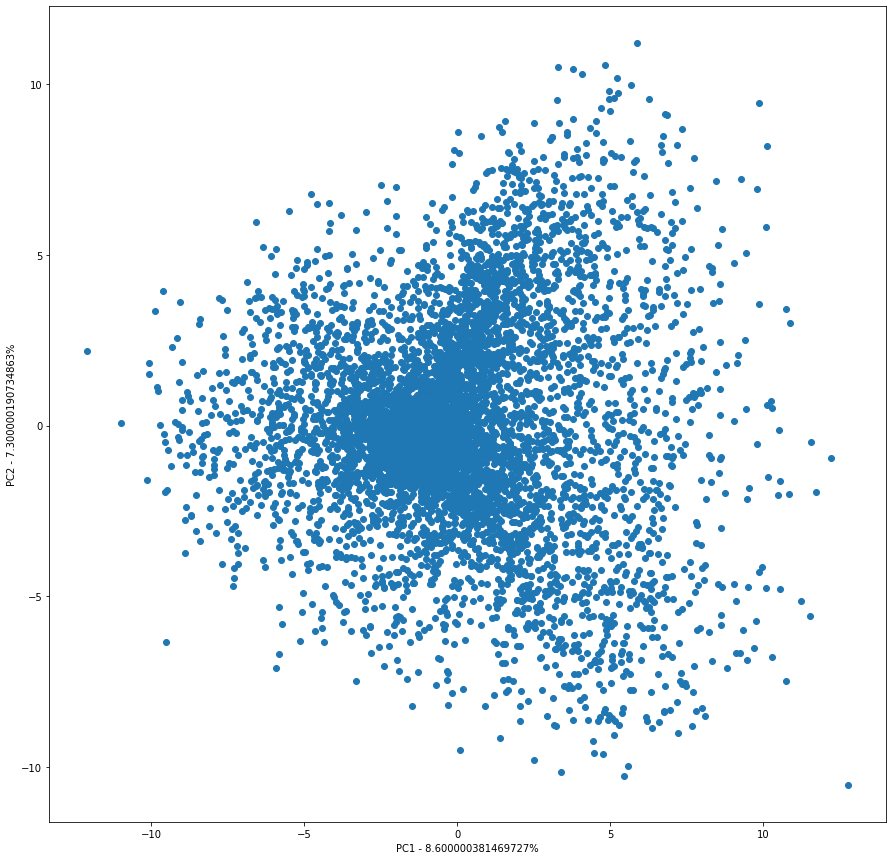

In [129]:
pca_df = pd.DataFrame(data=pca_data, index=df.index, columns=labels)

plt.figure(figsize=(15,15))

plt.scatter(pca_df.PC1, pca_df.PC2)
plt.xlabel('PC1 - {0}%'.format(round(per_var[0], 2)))
plt.ylabel('PC2 - {0}%'.format(round(per_var[1], 2)))
 
#for sample in pca_df.index:
#    if sample == 'Orkan':
#        plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]), size=20, color='red')
#    else:
#        plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]), size=16)
        
#plt.savefig('../references/inalco/orkan_pca.png', bbox_inches='tight')
plt.show()